<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/TensorFlow/02_fashion_mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify images **of clothing**


### Typical architecture of a classification network.
| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)) | Cross entropy ([`CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

> **Source:** <br> *Page 295 of [Hands-On Machine Learning Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

In [20]:
# Load the libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
print(f"Last Notebook run: {dt.datetime.now()}")

Last Notebook run: 2024-01-10 10:11:47.057402


# Get the **data**
[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset *(by Zalando, MIT License)*.

The contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution *(*28 by 28 pixels*)*

In [21]:
# load the data from keras
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [22]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [23]:
### What we want to classify? ###

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# The string represent the index which means zero rep. T-shirt

# Data **Exploration**

In [24]:
X_train.shape

(60000, 28, 28)

In [25]:
# Normalization
X_train = X_train / 255
X_test = X_test / 255

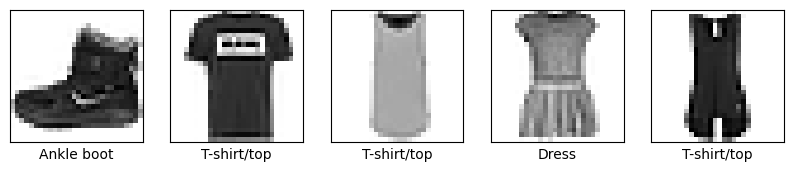

In [26]:
# Verify that the data is in the correct format

plt.figure(figsize=(10, 10))

for i in range(5):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[y_train[i]])

plt.show()

# Set initial **model**

In [27]:
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

[**`layers.Flatten`**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) transforms the formate of the input from a 2-dimensional array (28 by 28) to a one-dimensional array (28 * 28 = 784).

> **Also**, *`layers.Flatten` has nothing to do with the learning; it only changes the formate of the input to 1D.*



### **Compile** the model

In [28]:
# compile the model
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

[**`SparseCategoricalCrossentropy`**](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) is a loss function that you can use when there are two or more label classes.


<div><br></div>


> **NOTE:** labels should be provided as integers. If you want to provide labels using `one-hot` encoding (*e.g. [0, 1, 0...]*), then use `CategoricalCrossentropy` loss.

### **Train** the model
It called `model.fit` because it "*fits*" the model to the training data.

In [29]:
# fit the model
%%time
history = model.fit(X_train, y_train,
                    epochs=10, verbose=0, validation_split=0.2)

CPU times: user 38.1 s, sys: 3.73 s, total: 41.8 s
Wall time: 33.1 s


### **Evaluate** the model

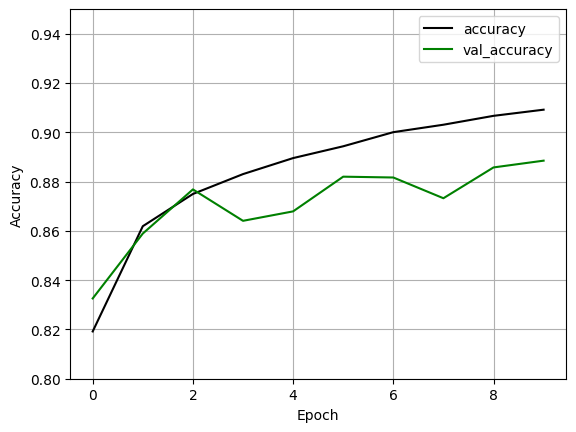

In [30]:
# see what the model have done...
hist = pd.DataFrame(history.history)


plt.plot(hist['accuracy'], label='accuracy', color='black')
plt.plot(hist['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim([0.80, 0.95])
plt.legend()

plt.show()

In [31]:
# See the accuracy on the test set
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.8791999816894531


The accuracy on the validation and test sets is a little less than the accuracy on the training set and this gab represents "*overfitting*".

> **Overfitting** is when you model learns the training data so well but it fails to deal with new, unseen data. <br>
(( *It's like memorizing a single test question so perfectly you can't answer it in a different way even if the wording changes slightly.* ))

# Improve the **model**
There are serveral strategies to deal with overfitting but I'll use L2 and dropout regularization.

In [32]:
# L2 and Dropout regularization

model_2 = keras.Sequential([
    # input layer
    layers.Flatten(input_shape=[28, 28]),

    # 3 hidden layers
    layers.Dense(64, activation='relu'),
    layers.Dense(96, activation='relu', kernel_regularizer='l2'),
    layers.Dense(64, activation='relu', kernel_initializer='GlorotUniform'),

    # dropout layer
    layers.Dropout(rate=0.2),

    # output layer
    layers.Dense(10, activation='softmax')
])

# compile the model
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [33]:
# fit the model
%%time
history_2 = model_2.fit(
    X_train, y_train,
    epochs=10, verbose=0,
    validation_split=0.2
)

CPU times: user 33.9 s, sys: 2.7 s, total: 36.6 s
Wall time: 42 s


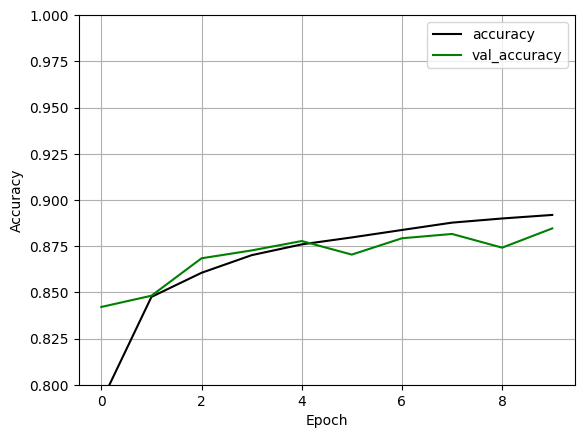

In [34]:
# see what the model have done...
hist_2 = pd.DataFrame(history_2.history)


plt.plot(hist_2['accuracy'], label='accuracy', color='black')
plt.plot(hist_2['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim([0.80, 1])
plt.legend()

plt.show()

**More about how to deal with overfitting**:
- [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting). TensorFlow